<a href="https://colab.research.google.com/github/andrehochuli/teaching/blob/main/ComputerVision/Lecture%2008%20-%20Classification/Lecture_08_Image_Classification-ClassNotes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#IMAGE CLASSIFICATION
In this jupyter notebook, we briefly reviewed well-known classifiers for image classification.


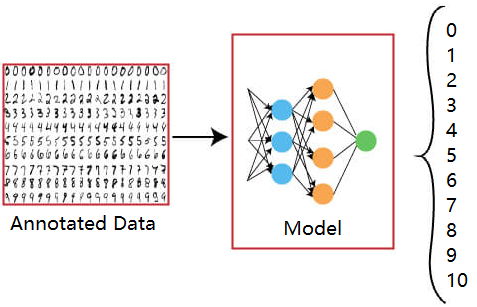

In [45]:
import numpy as np
import cv2, math
import matplotlib.pyplot as plt
#Keras to import datasets, not for deep learning (yet)
from tensorflow import keras
from sklearn.decomposition import PCA
from sklearn import metrics, preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd
import skimage.feature as feature


#Data Processing

This section collects the dataset and extracts the HOG features of each sample.

##Datasets

In [46]:
def load_digit_mnist():
  (x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
  lbls_name = ['0','1','2','3','4','5','6','7','8','9']

  return (x_train,y_train),(x_test, y_test),lbls_name

def load_fashion_mnist():
  (x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()
  lbl_names = ['T-shirt','Trouser','Pullover',
          'Dress','Coat','Sandal','Shirt','Sneaker',
          'Bag','Ankle boot']

  return (x_train,y_train),(x_test, y_test),lbls_name

def load_cifar_10():
  (x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
  lbls_name = ['0','1','2','3','4','5','6','7','8','9']
  y_train = y_train.reshape(-1)
  y_test = y_test.reshape(-1)
  return (x_train,y_train),(x_test, y_test),lbls_name

In [63]:
(x_train,y_train),(x_test, y_test),lbls_name = load_digit_mnist()
#(x_train,y_train),(x_test, y_test),lbls_name = load_fashion_mnist()
#(x_train,y_train),(x_test, y_test),lbls_name = load_cifar_10()
print(x_train.shape,y_train.shape,x_test.shape,y_test.shape)

(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)


In [64]:
#Auxiliary Function to plot side by side
def plot_sidebyside(img_list,titles=None,colormap=None,figsize=(12,6)):
  n = len(img_list)
  figure, axis = plt.subplots(1, n, figsize=figsize)

  if titles is None:
    titles = []
    A = ord('A')
    for i in range(n):
      titles.append(chr(A+i))

  for i in range(n):
    axis[i].imshow(img_list[i], cmap=colormap)
    axis[i].set_title(titles[i])
    axis[i].axis('off')
  # Combine all the operations and display
  plt.show()

##HOG Features
HoG – Histogram of Oriented Gradients
* Computes the gradient and orientation of edges
* Use a kernel to compute the Gradients (i.e 9x1)
* Patch-Based Histogram (8x8, 16x16..)


Below are exemplified the HOG features of an input image

In [65]:
class HOG:
  def describe(self,im,pixels_per_cell=(8, 8),cells_per_block=(2, 2)):
    if len(im.shape) > 2 and im.shape[2] == 3:
      im = cv2.cvtColor(im,cv2.COLOR_RGB2GRAY)

    im = cv2.resize(im,(64,128))

    fd, hog_image = feature.hog(im, orientations=9, pixels_per_cell=pixels_per_cell,
                	cells_per_block=cells_per_block,visualize=True)
    return fd,hog_image

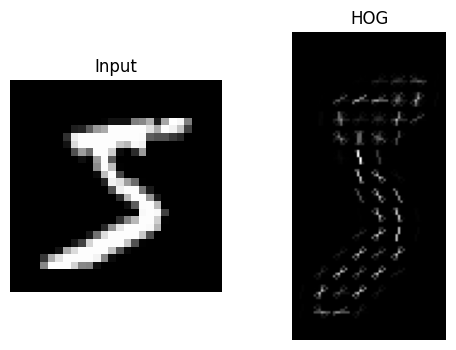

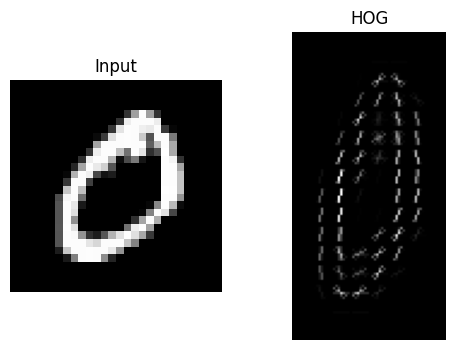

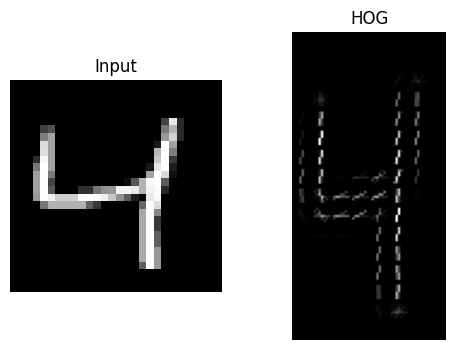

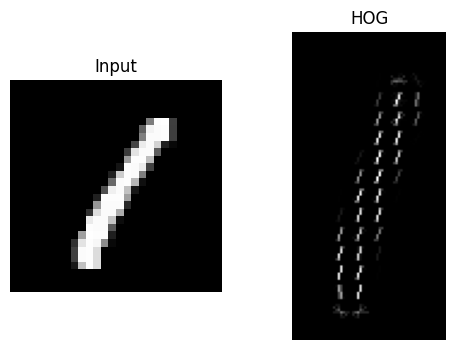

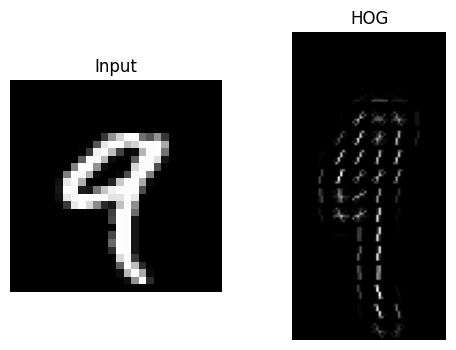

In [66]:
desc = HOG()
for img in x_train[:5]:
  key_pts, hog_img = desc.describe(img)
  plot_sidebyside([img,hog_img],
                ['Input','HOG'],
                colormap='gray',
                figsize=(6,4))


In [67]:
class LocalBinaryPatterns:
  def __init__(self, numPoints, radius):
    self.numPoints = numPoints
    self.radius = radius

  def describe(self, image, eps = 1e-7):
    if len(image.shape) > 2 and image.shape[2] == 3:
      image = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)

    lbp_img = feature.local_binary_pattern(image, self.numPoints, self.radius, method="uniform")
    (hist, _) = np.histogram(lbp_img.ravel(), bins=np.arange(0, self.numPoints+3), range=(0, self.numPoints + 2))

    # Normalize the histogram
    hist = hist.astype('float')
    hist /= (hist.sum() + eps)

    return hist, lbp_img

In [90]:
class GABOR:
    def __init__(self,ksize=31,n_filters=8):
        self.filters = []

        for theta in np.arange(0, np.pi, np.pi / n_filters):
            kern = cv2.getGaborKernel((ksize, ksize), 4.0, theta, 10.0, 0.5, 0, ktype=cv2.CV_32F)
            kern /= 1.5*kern.sum()
            self.filters.append(kern)

    def get_filters(self):
      return self.filters

    def describe(self,im):
        if len(im.shape) > 2 and im.shape[2] == 3:
          im = cv2.cvtColor(im,cv2.COLOR_RGB2GRAY)

        gabor_img = np.zeros_like(im)
        for kern in self.filters:
            f_im = cv2.filter2D(im, cv2.CV_8UC3, kern)
            np.maximum(gabor_img, f_im, gabor_img)

        return gabor_img.reshape(-1), gabor_img


In [91]:
#desc = HOG()
#desc = LocalBinaryPatterns(8, 2)
desc = GABOR(32,9)
N_SAMPLES_TRAIN = 4000
N_SAMPLES_TEST = 500

features = {'train': [], 'test': []}
for img, lbl in zip(x_train[:N_SAMPLES_TRAIN],y_train[:N_SAMPLES_TRAIN]):

  feat, _ = desc.describe(img)
  features['train'].append(feat)

#Add to a dictionary
features['train'] = np.reshape(features['train'],(N_SAMPLES_TRAIN,-1))
print('Train Data: ',features['train'].shape)



for img, lbl in zip(x_test[:N_SAMPLES_TEST],y_test[:N_SAMPLES_TEST]):
  feat, _ = desc.describe(img)
  features['test'].append(feat)

#Add to a dictionary
features['test'] = np.reshape(features['test'],(N_SAMPLES_TEST,-1))
print('Test Data: ',features['test'].shape)




Train Data:  (4000, 784)
Test Data:  (500, 784)


#Data Normalization

Normalizing data is important in distorting differences in the ranges of values.

In [92]:
data = features['train']
print(data[0])

print(np.unique(data[0]))

print("STD Scaler")
data_norm = preprocessing.StandardScaler().fit_transform(data)
print(np.unique(data_norm[0]))

print("MinMax Scaler")
data_norm = preprocessing.MinMaxScaler().fit_transform(data)
print(np.unique(data_norm[0]))



[100  98  88  76 102 104  80  44  61  63 108 166 192 188 163 128  89  75
  80  82  75  59  36  52 119 174 212 226 100 104 100  91 114 137 129  92
  78  91 108 166 193 188 162 127  89  91  88  81  76  64 107 167 210 231
 228 200  95 107 112 110 109 155 171 150  98 118 121 166 192 186 161 127
 104  98 100  97 106 174 225 253 255 234 189 127  78 100 118 127 126 150
 195 200 164 140 158 163 190 185 162 132 112 126 126 190 247 255 255 255
 238 177 103  25  43  76 108 132 145 147 190 231 225 173 189 185 189 188
 169 143 149 211 255 255 255 255 255 232 201 188 170 148  33  67  96 123
 146 165 180 230 255 245 207 220 192 195 190 242 255 255 255 255 255 255
 255 255 255 255 255 236  73 102 131 162 193 221 247 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 250 108 118
 133 155 181 209 237 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 226 204 191 128 149 177 209 245 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 243 220 19

In [93]:
data_norm_train = preprocessing.MinMaxScaler().fit_transform(features['train'])
data_norm_test = preprocessing.MinMaxScaler().fit_transform(features['test'])

#Feature Space Visualization

The PCA analisys is useful to reduce the feature space and then, visualize it.

Lets do it:

(4000, 784)


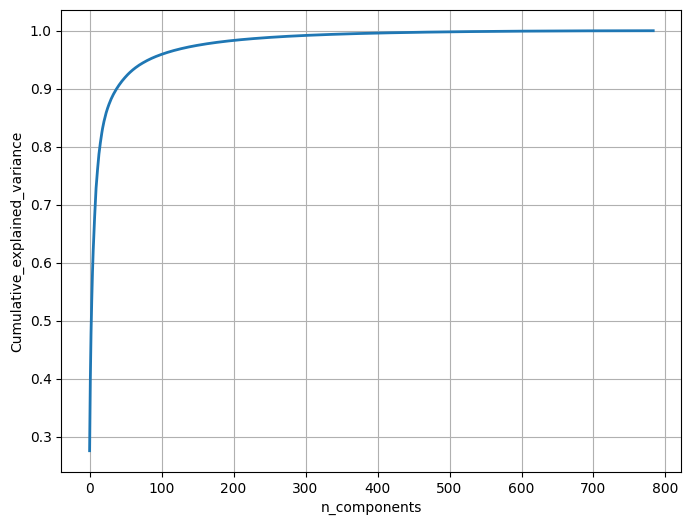

In [94]:
from sklearn.decomposition import PCA

print(data_norm_train.shape)
n_features = data_norm_train.shape[1]
pca = PCA(n_components=n_features)
reduced_data = pca.fit_transform(data_norm_train)
percentage_var_explained = pca.explained_variance_ / np.sum(pca.explained_variance_)
cum_var_explained = np.cumsum(percentage_var_explained)

plt.figure(figsize=(8, 6))
plt.clf()
plt.plot(cum_var_explained, linewidth=2)
plt.axis('tight')
plt.grid()
plt.xlabel('n_components')
plt.ylabel('Cumulative_explained_variance')
plt.show()


In [95]:
  import plotly.graph_objs as go
import plotly.express as px
import numpy as np
from sklearn.decomposition import PCA


# carregando o conjunto de dados iris

# Redução de dimensionalidade usando PCA para 3 dimensões
pca = PCA(n_components=3)
pca_components = pca.fit_transform(data_norm_train[:500])

# Plotando a visualização PCA em 3D
fig = px.scatter_3d(x=pca_components[:, 0], y=pca_components[:, 1], z=pca_components[:, 2], color=y_train[:500])
fig.show()

In [106]:
from sklearn.manifold import TSNE

# Redução de dimensionalidade usando t-SNE para 3 dimensões
tsne = TSNE(n_components=3, random_state=42)
tsne_components = tsne.fit_transform(data_norm_train[:4000])



In [107]:
# Plotando a visualização t-SNE em 3D
fig = px.scatter_3d(x=tsne_components[:, 0], y=tsne_components[:, 1], z=tsne_components[:, 2], color=y_train[:4000])
fig.show()


#Classification

This section evaluates several well-know classifiers

* KNN
* Logistic Regression
* Naive Bayes
* Decision Tree
* Support Vector Machine
* Multi-Layer Perceptron



In [96]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

K=3
max_iter = 100

models = {}
models['KNN'] = KNeighborsClassifier(n_neighbors=3)
models['NB'] = MultinomialNB()
models['LR'] = LogisticRegression(max_iter=max_iter)
models['DT'] = DecisionTreeClassifier(max_depth=5)
models['SVC'] = SVC(max_iter=max_iter,kernel='linear')
models['MLP'] = MLPClassifier(max_iter=max_iter)

In [98]:
def performance_evaluation(y_test, predictions,info_message,figsize=(18, 4)):

  print(f"Evaluation of ", info_message)
  print(f"{metrics.classification_report(y_test, predicted)}\n")
  print(lbls_name)
  disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, predictions)
  disp.figure_.suptitle("Confusion Matrix")
  plt.show()
  print('\n')
  id = np.random.randint(300)
  idx1,idx2=id,id+20
  diff = np.absolute(y_test.astype(np.int32) - predictions)
  idxs = np.where(diff == 0)

  _, axes = plt.subplots(nrows=1, ncols=(idx2-idx1), figsize=figsize)
  for ax, image, lbl, prediction, in zip(axes, x_test[idxs],y_test[idxs], predictions[idxs]):
      ax.set_axis_off()
      ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
      ax.set_title(f'Label: {lbl}')
      ax.text(0.5, 0.0, f'Pred: {prediction}', ha='center', va='center', transform=ax.transAxes)

  idxs = np.where(diff != 0)
  plt.show()

  print('\n')
  _, axes = plt.subplots(nrows=1, ncols=(idx2-idx1), figsize=figsize)
  for ax, image, lbl, prediction, in zip(axes, x_test[idxs],y_test[idxs], predictions[idxs]):
      ax.set_axis_off()
      ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
      ax.set_title(f'Label: {lbl}')
      ax.text(0.5, 0.0, f'Pred: {prediction}', ha='center', va='center', transform=ax.transAxes)
  plt.show()
  print('\n')

##Training and Evaluate

In [99]:
print(y_train[:N_SAMPLES_TRAIN].shape)

(4000,)


In [100]:
print(data_norm_train[34],y_train[34])

[0.07874016 0.08267717 0.1023622  0.14285714 0.18253968 0.24015748
 0.2687747  0.28235294 0.29019608 0.43921569 0.54901961 0.5372549
 0.38431373 0.49803922 0.50196078 0.92156863 1.         1.
 1.         1.         0.85657371 0.40784314 0.57647059 0.58565737
 0.5952381  0.47808765 0.61111111 0.65737052 0.07480315 0.09090909
 0.11904762 0.15079365 0.1752988  0.22088353 0.29718876 0.35080645
 0.37903226 0.4516129  0.49794239 0.61344538 0.59243697 0.47107438
 0.54237288 1.         1.         1.         1.         1.
 0.84518828 0.70042194 0.70954357 0.58606557 0.54065041 0.66
 0.68525896 0.61752988 0.07086614 0.0952381  0.12698413 0.14285714
 0.14342629 0.17670683 0.26720648 0.36178862 0.44715447 0.5
 0.48535565 0.57692308 0.71308017 0.68220339 0.71794872 1.
 1.         1.         1.         1.         0.875      0.87341772
 0.70661157 0.66938776 0.76422764 0.76209677 0.66532258 0.49206349
 0.08333333 0.08730159 0.11507937 0.11155378 0.09561753 0.12
 0.21052632 0.29795918 0.41803279 0.530

#########################
Training KNN
[7 2 1 0 4 1 4 9 5 9] [7 2 1 0 4 1 4 9 5 9]
Evaluation of  KNN
              precision    recall  f1-score   support

           0       0.91      0.98      0.94        42
           1       0.93      1.00      0.96        67
           2       0.96      0.93      0.94        55
           3       0.93      0.82      0.87        45
           4       0.96      0.80      0.87        55
           5       0.87      0.94      0.90        50
           6       0.87      0.95      0.91        43
           7       0.89      0.96      0.92        49
           8       0.85      0.70      0.77        40
           9       0.79      0.83      0.81        54

    accuracy                           0.90       500
   macro avg       0.90      0.89      0.89       500
weighted avg       0.90      0.90      0.89       500


['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


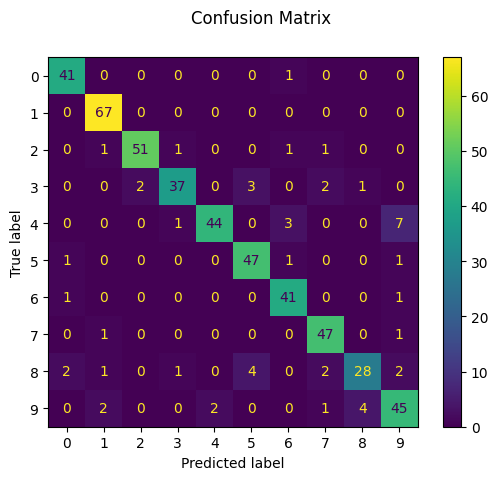

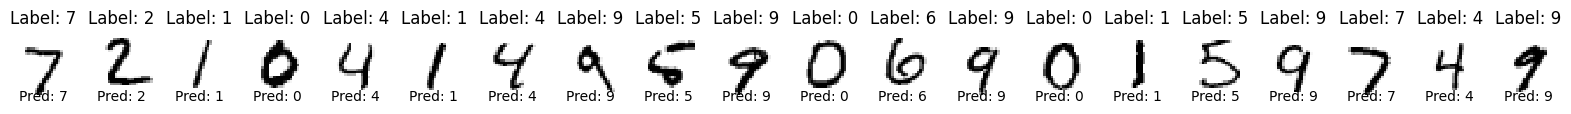

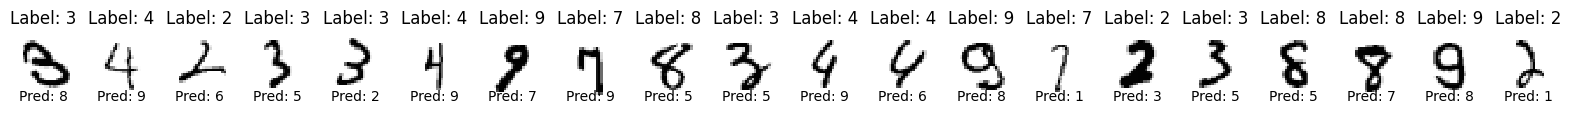



#########################
Training NB
[7 2 1 0 4 1 4 9 5 9] [7 2 1 0 4 1 4 2 5 7]
Evaluation of  NB
              precision    recall  f1-score   support

           0       0.90      0.88      0.89        42
           1       0.95      0.93      0.94        67
           2       0.82      0.82      0.82        55
           3       0.60      0.87      0.71        45
           4       0.66      0.71      0.68        55
           5       0.88      0.56      0.68        50
           6       0.76      0.65      0.70        43
           7       0.81      0.69      0.75        49
           8       0.61      0.57      0.59        40
           9       0.59      0.72      0.65        54

    accuracy                           0.75       500
   macro avg       0.76      0.74      0.74       500
weighted avg       0.76      0.75      0.75       500


['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


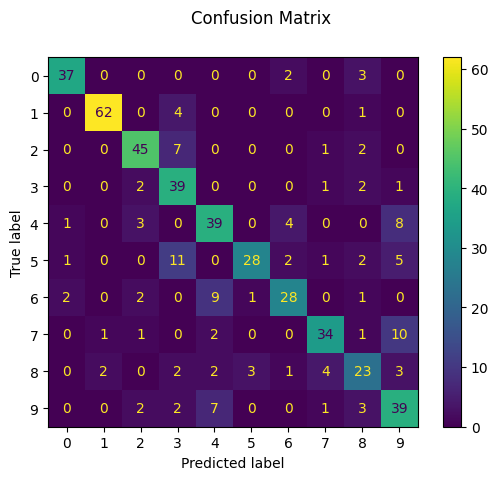

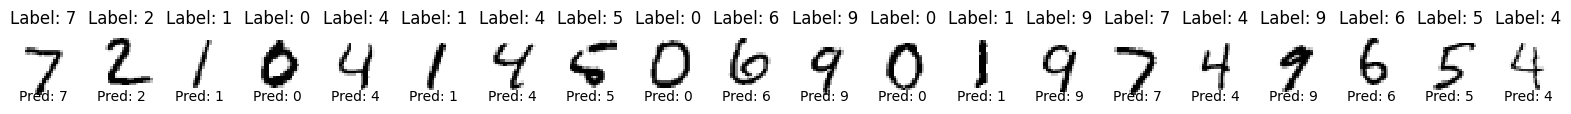

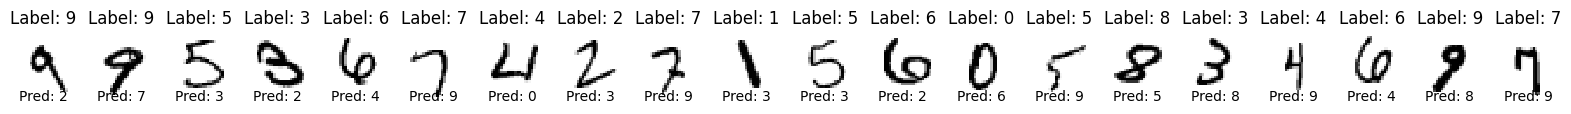



#########################
Training LR


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[7 2 1 0 4 1 4 9 5 9] [7 2 1 0 4 1 4 9 5 9]
Evaluation of  LR
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        42
           1       0.99      0.99      0.99        67
           2       0.98      0.89      0.93        55
           3       0.83      0.89      0.86        45
           4       0.96      0.84      0.89        55
           5       0.94      0.94      0.94        50
           6       0.85      0.95      0.90        43
           7       0.88      0.94      0.91        49
           8       0.80      0.82      0.81        40
           9       0.81      0.81      0.81        54

    accuracy                           0.91       500
   macro avg       0.90      0.90      0.90       500
weighted avg       0.91      0.91      0.91       500


['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


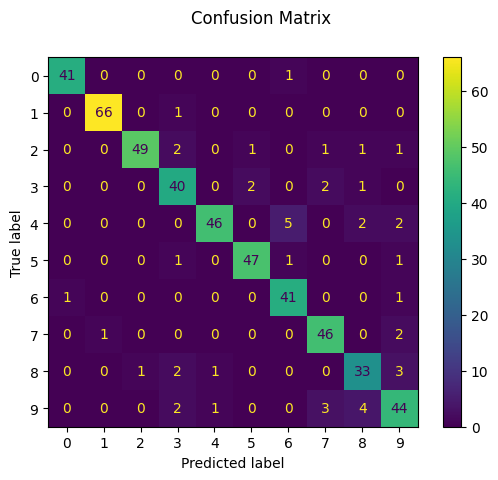

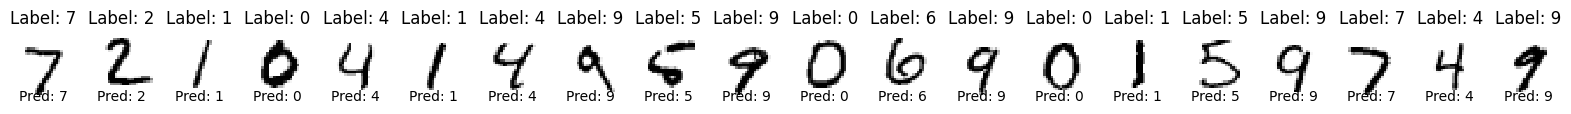

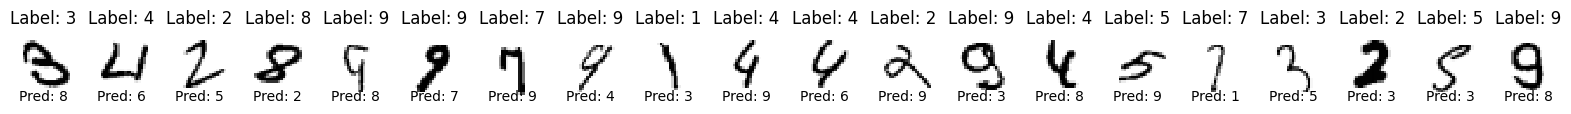



#########################
Training DT
[7 2 1 0 4 1 4 9 5 9] [7 2 1 0 4 1 4 9 9 9]
Evaluation of  DT
              precision    recall  f1-score   support

           0       0.90      0.90      0.90        42
           1       0.94      0.93      0.93        67
           2       0.37      0.65      0.47        55
           3       0.40      0.49      0.44        45
           4       0.58      0.38      0.46        55
           5       0.68      0.26      0.38        50
           6       0.42      0.23      0.30        43
           7       0.84      0.55      0.67        49
           8       1.00      0.05      0.10        40
           9       0.36      0.85      0.51        54

    accuracy                           0.55       500
   macro avg       0.65      0.53      0.52       500
weighted avg       0.65      0.55      0.53       500


['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


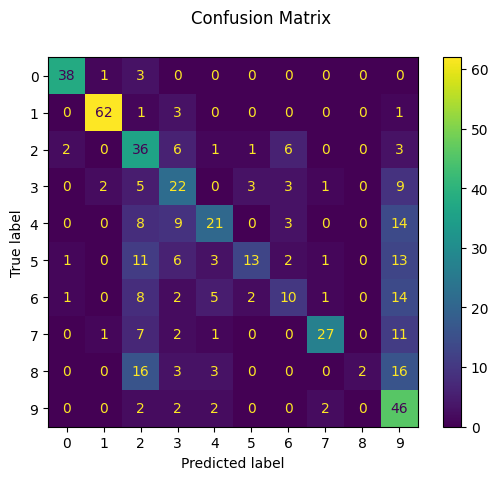

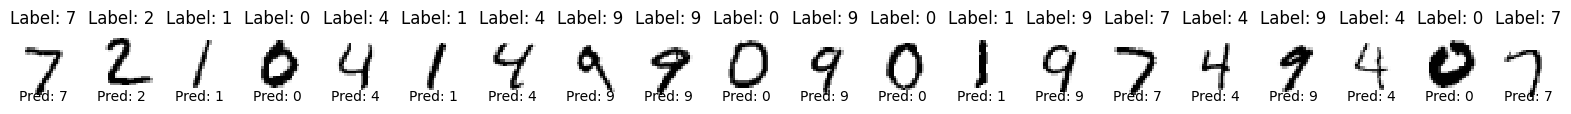

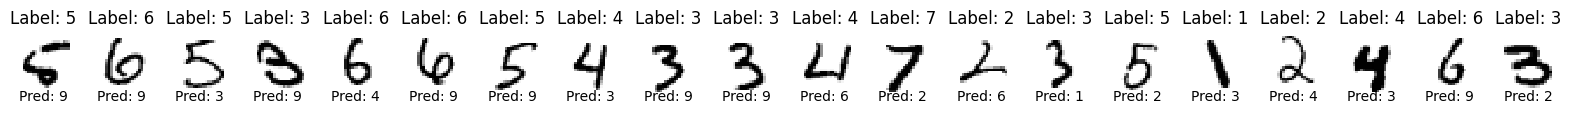



#########################
Training SVC


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning:

Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[7 2 1 0 4 1 4 9 5 9] [7 2 1 0 4 1 4 9 5 9]
Evaluation of  SVC
              precision    recall  f1-score   support

           0       0.95      0.98      0.96        42
           1       0.96      0.99      0.97        67
           2       0.96      0.91      0.93        55
           3       0.85      0.87      0.86        45
           4       0.96      0.87      0.91        55
           5       0.88      0.92      0.90        50
           6       0.89      0.95      0.92        43
           7       0.88      0.92      0.90        49
           8       0.89      0.78      0.83        40
           9       0.82      0.85      0.84        54

    accuracy                           0.91       500
   macro avg       0.90      0.90      0.90       500
weighted avg       0.91      0.91      0.91       500


['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


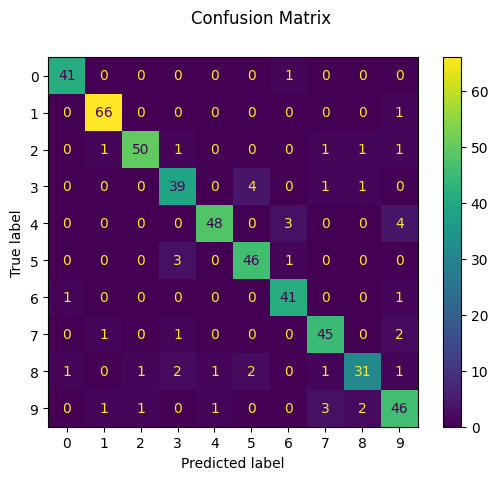

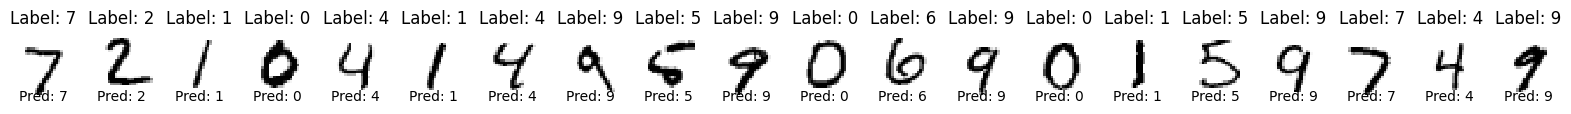

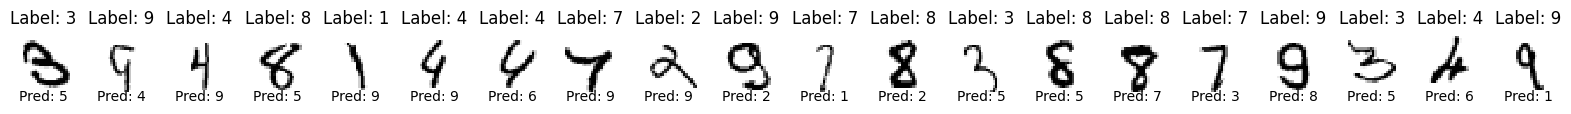



#########################
Training MLP


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.



[7 2 1 0 4 1 4 9 5 9] [7 2 1 0 4 1 4 9 5 9]
Evaluation of  MLP
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        42
           1       1.00      1.00      1.00        67
           2       0.94      0.93      0.94        55
           3       0.91      0.91      0.91        45
           4       0.98      0.84      0.90        55
           5       0.98      0.98      0.98        50
           6       0.93      0.95      0.94        43
           7       0.89      0.96      0.92        49
           8       0.80      0.82      0.81        40
           9       0.84      0.87      0.85        54

    accuracy                           0.93       500
   macro avg       0.93      0.93      0.93       500
weighted avg       0.93      0.93      0.93       500


['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


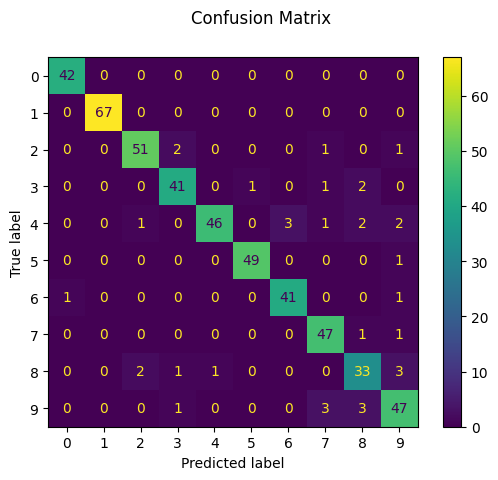

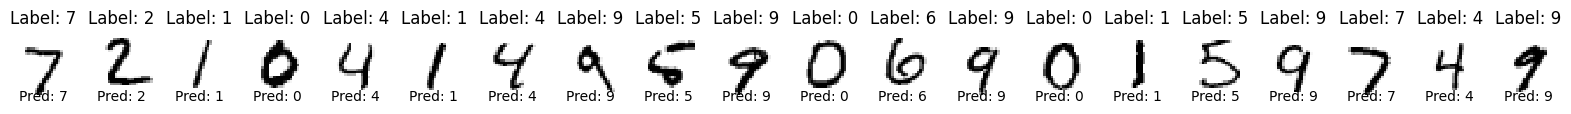

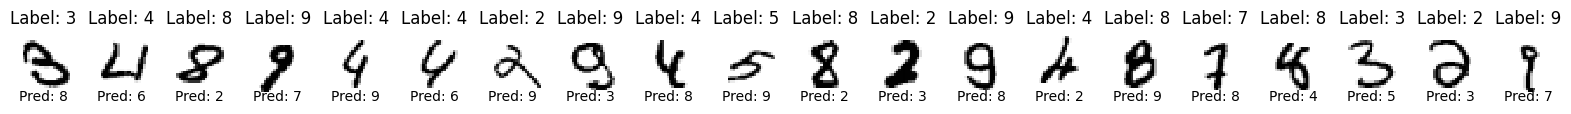

In [101]:
for name in models:
  print('#########################')
  print(f'Training {name}')

  train = data_norm_train
  test = data_norm_test

  model = models[name]
  model.fit(train, y_train[:N_SAMPLES_TRAIN])
  predicted = model.predict(test)
  print(y_test[:10],predicted[:10])
  performance_evaluation(y_test[:N_SAMPLES_TEST],predicted,name,figsize=(20,8))

